#**Notes on Theia 456 project**

**plotting parameters**

In [1]:
aw = 1.5
ax_size = 20 
color_background = 'lightgray'

**Mount Google Drive and set up directories**

In [2]:
# Directories
project_name = 'Theia_456'
dir_drive = "/content/gdrive/My Drive/"
dir_project = dir_drive+'Projects/'+project_name+'/'
dir_plots = dir_project+'Plots/'

# Mount Drive
# You have to give permission to the notebook to access files stored in your Google Drive. 
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


**Import python modules available to Colab or pip-installable**

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # for multi-panel figures

from glob import glob
import pandas as pd
import numpy as np
import astropy.units as units
from astropy.io import fits # Reads tables
from astropy.io import ascii
from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord


In [4]:
# astroquery
!pip install astroquery
from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch

     |████████████████████████████████| 3.9MB 29.0MB/s 
     |████████████████████████████████| 808kB 33.4MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 3.2MB 42.1MB/s 
  Created wheel for mimeparse: filename=mimeparse-0.1.3-cp37-none-any.whl size=3864 sha256=8b0b83586fd8d4494682cabe4caf96e100d412bedee8d5797a202a7c4143fba1
  Stored in directory: /root/.cache/pip/wheels/54/ca/c7/3db47cc5c748286db22a7fab43ccf985903d2b9ca119de16ab
Successfully built mimeparse
Could not import regions, which is required for some of the functionalities of this module.


**Exctinction Coefficients**

from the Gaia Collaboration (2018)'s Hertzsprung$-$Russell Diagram paper: https://ui.adsabs.harvard.edu/abs/2018A%26A...616A..10G/abstract

The coefficients depend on spectral type and the amount of extinction. 

In [5]:
def AG_Law(colors, Av):
  # 0.9761 −0.1704 0.0086 0.0011 −0.0438 0.0013 0.0099

  coeff = np.array([0.9761, -0.1704, 0.0086, 0.0011, -0.0438, 0.0013, 0.0099])
  return coeff[0] + coeff[1]*colors + coeff[2]*colors**2 + coeff[3]*colors**3 + coeff[4]*Av + coeff[5]*Av**2 + coeff[6]*Av*colors

def EBR_Law(colors, Av):
  coeff_BP = np.array([1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043])
  #  1.1517 −0.0871 −0.0333 0.0173 −0.0230 0.0006 0.0043

  coeff_RP = np.array([0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006])
  # 0.6104 −0.0170 −0.0026 −0.0017 −0.0078 0.00005 0.0006
  ABP = coeff_BP[0] + coeff_BP[1]*colors + coeff_BP[2]*colors**2 + coeff_BP[3]*colors**3 + coeff_BP[4]*Av + coeff_BP[5]*Av**2 + coeff_BP[6]*Av*colors
  ARP = coeff_RP[0] + coeff_RP[1]*colors + coeff_RP[2]*colors**2 + coeff_RP[3]*colors**3 + coeff_RP[4]*Av + coeff_RP[5]*Av**2 + coeff_RP[6]*Av*colors
  return ABP-ARP


AG_Law(0.82, 0.1), EBR_Law(0.82,0.1)

(0.8392059448, 0.47244021199999964)

**Load Theia Catalog**

In [6]:
# Load Theia catalog
f = glob(dir_drive+'Tables/Theia_Table.fits')
hdul = fits.open(f[0])
theia_data = hdul[1].data
theia_data.columns

ColDefs(
    name = 'SOURCE_ID'; format = 'K'; null = -9223372036854775808
    name = 'PROB'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'PARALLAX'; format = 'E'
    name = 'VLSRRA'; format = 'E'
    name = 'VLSRDEC'; format = 'E'
    name = 'L'; format = 'D'
    name = 'L1'; format = 'D'
    name = 'B'; format = 'D'
    name = 'VLSRL'; format = 'E'
    name = 'VLSRB'; format = 'E'
    name = 'SLABEL'; format = 'J'; null = -2147483648
    name = 'VLSRV'; format = 'D'
    name = 'NAME'; format = '17A'
    name = 'PLOTNAME'; format = '23A'
    name = 'ID'; format = 'J'; null = -2147483648
    name = 'G'; format = 'D'
    name = 'EG'; format = 'D'
    name = 'BP'; format = 'D'
    name = 'EBP'; format = 'D'
    name = 'RP'; format = 'D'
    name = 'ERP'; format = 'D'
    name = 'J'; format = 'E'
    name = 'EJ'; format = 'E'
    name = 'H'; format = 'E'
    name = 'EH'; format = 'E'
    name = 'K'; format = 'E'
    name = 'EK'; format = 'E'
    na

**Identify Theia 456 stars and extract parameters**

In [7]:
i456 = np.where(theia_data['ID'] == 456)[0]
print("There are "+str(len(i456))+" stars associated with Theia 456")

Theia456_RA = np.array(theia_data['DEC'][i456],dtype=float)
Theia456_Dec = np.array(theia_data['DEC'][i456],dtype=float)                         
Theia456_bprp = np.array(theia_data['BP'][i456] - theia_data['RP'][i456],dtype=float)
Theia456_Gmag = np.array(theia_data['G'][i456],dtype=float)
Theia456_dm = np.array(5*np.log10(100/theia_data['PARALLAX'][i456]),dtype=float)
Theia456_MG = Theia456_Gmag - Theia456_dm

There are 478 stars associated with Theia 456


**Cross-match with LAMOST DR5 official FGK catalog**

We are going to use a 2 arsecond search radius. For stars with multiple spectra, we will select the data from the spectrum with the lowest quoted Teff error.

In [8]:
f = glob(dir_drive+'Tables/dr5*')
lamost_catalog = fits.open(f[0])
lamost_catalog.info()
lamost_data = lamost_catalog[1].data
lam_ra = lamost_data['ra']
lam_dec = lamost_data['dec']
lamost_data.columns

Filename: /content/gdrive/My Drive/Tables/dr5_v3_stellar.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      17   ()      
  1                1 BinTableHDU    157   5348712R x 44C   [J, 19A, 10A, J, J, 40A, B, B, D, D, E, E, E, E, E, 16A, 20A, 20A, E, E, 25A, E, E, E, E, E, E, E, 16A, 10A, 60A, 60A, B, E, D, D, E, E, E, E, E, E, E, E]   


ColDefs(
    name = 'obsid'; format = 'J'; disp = 'I8'
    name = 'designation'; format = '19A'; disp = 'A19'
    name = 'obsdate'; format = '10A'; disp = 'A10'
    name = 'lmjd'; format = 'J'
    name = 'mjd'; format = 'J'
    name = 'planid'; format = '40A'; disp = 'A40'
    name = 'spid'; format = 'B'; disp = 'I2'
    name = 'fiberid'; format = 'B'; disp = 'I3'
    name = 'ra_obs'; format = 'D'; unit = 'deg'; disp = 'F16.10'
    name = 'dec_obs'; format = 'D'; unit = 'deg'; disp = 'F16.10'
    name = 'snru'; format = 'E'; disp = 'F6.2'
    name = 'snrg'; format = 'E'; disp = 'F6.2'
    name = 'snrr'; format = 'E'; disp = 'F6.2'
    name = 'snri'; format = 'E'; disp = 'F6.2'
    name = 'snrz'; format = 'E'; disp = 'F6.2'
    name = 'objtype'; format = '16A'; disp = 'A16'
    name = 'class'; format = '20A'; disp = 'A20'
    name = 'subclass'; format = '20A'; disp = 'A20'
    name = 'z'; format = 'E'; disp = 'F21.10'
    name = 'z_err'; format = 'E'; disp = 'F21.10'
    name = 'magtype

In [9]:
search_radius = 2
n_stars = len(i456)
id_xmatch = np.empty(n_stars, dtype=object)
teff = np.zeros(n_stars, dtype=float) +np.nan
e_teff = np.zeros(n_stars, dtype=float) +np.nan
feh = np.zeros(n_stars, dtype=float) +np.nan
e_feh = np.zeros(n_stars, dtype=float) +np.nan
rv = np.zeros(n_stars, dtype=float) +np.nan
e_rv = np.zeros(n_stars, dtype=float) +np.nan

for i in range(n_stars):
  rad = np.sqrt((theia_data['RA'][i456[i]] - lam_ra)**2+(theia_data['DEC'][i456[i]] - lam_dec)**2)
  imatch = np.where(rad*3600 < search_radius)[0]
  if len(imatch) == 1:
    id_xmatch[i] = imatch[0]
    teff[i] = lamost_data['teff'][imatch[0]]
    e_teff[i] = lamost_data['teff_err'][imatch[0]]
    feh[i] = lamost_data['feh'][imatch[0]]
    e_feh[i] = lamost_data['feh_err'][imatch[0]]
    rv[i] = lamost_data['rv'][imatch[0]]        
    e_rv[i] = lamost_data['rv_err'][imatch[0]]
  if len(imatch) > 1:
    teff_errors = np.array(lamost_data['teff_err'][imatch])
    iuse = np.argmin(teff_errors)
    print(i, teff_errors)
    imatch = imatch[iuse]
    id_xmatch[i] = imatch
    teff[i] = lamost_data['teff'][imatch]
    e_teff[i] = lamost_data['teff_err'][imatch]
    feh[i] = lamost_data['feh'][imatch]
    e_feh[i] = lamost_data['feh_err'][imatch]
    rv[i] = lamost_data['rv'][imatch]        
    e_rv[i] = lamost_data['rv_err'][imatch]

teff  

42 [243.97 360.67 105.32 118.14]
44 [211.5   94.92]
68 [228.43  18.87  63.42  25.47]
70 [ 92.01  16.67  19.79 118.71]
82 [247.36 176.22]
85 [48.48 46.95]
86 [ 59.09  49.37 115.01]
91 [63.17 44.71]
92 [204.64  41.63]
93 [57.13 25.4  33.32]
135 [232.21  95.3  115.83]
153 [33.64 15.41]
178 [161.35 100.52]
183 [ 40.92 141.84]
210 [78.88 35.97]
257 [308.85  27.12]
288 [57.1  33.83]
302 [177.32  70.39]
309 [207.24  38.04]
317 [135.01 131.18]
318 [29.94 53.23]
333 [70.04 53.5 ]
373 [117.57 144.19]
412 [133.49  88.37  21.46]
451 [34.11 25.08]
454 [14.38 21.14]
455 [16.17 13.11]


array([3911.72998047,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan, 6031.60986328, 5709.75      ,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan, 5761.62011719,
                 nan,           nan,           nan, 5477.14990234,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan, 5645.70019531,           nan,
       6054.25976562,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           

In [10]:
# package the results of the cross-match.
Theia456_LAMOST = pd.DataFrame({'Teff':teff, 'e_Teff':e_teff, '[Fe/H]':feh, 'e_[Fe/H]':e_feh, 'RV':rv, 'e_RV':e_rv})

#**Pleiades**

Now, let's do the Pleiades for reference. We will use the Gaia Collaboration's membership list for simplicity (same HRD paper referenced earlier).

**Pleiades membership**

In [11]:
# Download Gaia Collaboration catalog
# We will use Gaia Collaboration (2018) lists for now.
vizier_gaia_clusters_near = "J/A+A/616/A10/tablea1a"
vizier_gaia_clusters_far = "J/A+A/616/A10/tablea1b"

qcat = Vizier(column_filters={'Cluster':'Pleiades'})
qcat.ROW_LIMIT = -1
Pleiades_catalog = qcat.get_catalogs(vizier_gaia_clusters_near)[0]
print(len(Pleiades_catalog))

# Cross-match with Gaia EDR3
search_radius = 0.8
Pleiades_edr3 = XMatch.query(cat1=Pleiades_catalog,
                    cat2='vizier:I/350/gaiaedr3',
                    max_distance=search_radius * units.arcsec, 
                    colRA1='RAdeg', colDec1='DEdeg')

# Cross-match with Gaia DR2 so we have consistent photometry for the two clusters.
Pleiades_dr2 = XMatch.query(cat1=Pleiades_catalog,
                    cat2='vizier:I/345/gaia2',
                    max_distance=search_radius * units.arcsec, 
                    colRA1='RAdeg', colDec1='DEdeg')

print("Number of Gaia-matched sources:  "+str(len(Pleiades_edr3)))  

1326
Number of Gaia-matched sources:  1178


In [12]:
Pleiades_bprp = np.array(Pleiades_dr2['bp_rp'],dtype=float)

**Pleiades LAMOST**

In [13]:
search_radius = 2
n_stars = len(Pleiades_dr2)
pleiades_id_xmatch = np.empty(n_stars, dtype=object)
pleiades_teff = np.zeros(n_stars, dtype=float) +np.nan
pleiades_e_teff = np.zeros(n_stars, dtype=float) +np.nan
pleiades_feh = np.zeros(n_stars, dtype=float) +np.nan
pleiades_e_feh = np.zeros(n_stars, dtype=float) +np.nan
pleiades_rv = np.zeros(n_stars, dtype=float) +np.nan
pleiades_e_rv = np.zeros(n_stars, dtype=float) +np.nan

for i in range(n_stars):
  rad = np.sqrt((Pleiades_dr2['ra'][i] - lam_ra)**2+(Pleiades_dr2['dec'][i] - lam_dec)**2)
  imatch = np.where(rad*3600 < search_radius)[0]
  if len(imatch) == 1:
    pleiades_id_xmatch[i] = imatch[0]
    pleiades_teff[i] = lamost_data['teff'][imatch[0]]
    pleiades_e_teff[i] = lamost_data['teff_err'][imatch[0]]
    pleiades_feh[i] = lamost_data['feh'][imatch[0]]
    pleiades_e_feh[i] = lamost_data['feh_err'][imatch[0]]
    pleiades_rv[i] = lamost_data['rv'][imatch[0]]        
    pleiades_e_rv[i] = lamost_data['rv_err'][imatch[0]]
  if len(imatch) > 1:
    teff_errors = np.array(lamost_data['teff_err'][imatch])
    iuse = np.argmin(teff_errors)
    print(i, teff_errors)
    imatch = imatch[iuse]
    pleiades_id_xmatch[i] = imatch
    pleiades_teff[i] = lamost_data['teff'][imatch]
    pleiades_e_teff[i] = lamost_data['teff_err'][imatch]
    pleiades_feh[i] = lamost_data['feh'][imatch]
    pleiades_e_feh[i] = lamost_data['feh_err'][imatch]
    pleiades_rv[i] = lamost_data['rv'][imatch]        
    pleiades_e_rv[i] = lamost_data['rv_err'][imatch]

2 [28.92 24.42]
8 [43.48 43.94]
16 [18.6  18.59 16.67]
28 [17.33 17.95]
48 [72.17 78.65]
54 [244.95  76.16]
58 [16.34 19.2  13.73]
74 [111.67  64.34]
75 [17.06 19.11 14.71]
103 [176.75 171.47]
109 [ 34.78  50.89 120.59]
125 [36.24 55.02]
150 [78.79 44.01]
156 [20.6  25.59 20.71]
191 [28.96 28.2 ]
207 [61.61 26.96]
261 [48.1  36.08]
277 [15.51 65.04]
280 [67.98 70.27]
288 [17.41 11.37 11.1 ]
295 [19.66 21.07]
299 [16.54 15.05 12.29 11.5 ]
300 [19.11 29.14 19.29 18.12]
317 [73.47 45.32 51.89]
320 [42.4  38.81]
322 [20.24 29.77 29.01 22.09]
332 [30.71 30.72]
339 [83.05 94.17]
364 [60.72 68.58 51.61]
367 [12.08 19.75]
373 [20.6  27.46]
384 [128.61 130.66 114.68]
385 [51.25 44.3 ]
386 [38.39 80.46]
389 [44.02 41.23]
396 [9.33 7.43]
409 [121.44 130.4   47.46]
410 [36.19 24.37 33.58]
423 [102.69 110.78]
425 [16.81 22.03]
427 [18.34 14.76 18.19]
430 [64.07 61.88]
434 [104.27  63.5 ]
466 [13.22 17.94]
469 [16.5  58.37]
475 [-9.999e+03  6.450e+00]
481 [43.51 54.77]
482 [ 23.67  27.   127.76]
490

In [14]:
# package the results of the cross-match.
Pleiades_LAMOST = pd.DataFrame({'Teff':pleiades_teff, 'e_Teff':pleiades_e_teff, '[Fe/H]':pleiades_feh, 'e_[Fe/H]':pleiades_e_feh, 'RV':pleiades_rv, 'e_RV':pleiades_e_rv, 'BP-RP':Pleiades_bprp})

**An empirical color$-$temperature relation based on the Pleiades.** 

We plot the Gaia DR2 ($G_{\rm BP} - G_{\rm RP}$) color vs. LAMOST $T_{\rm eff}$, select a subset of stars that tightly follow the relationship, then fit a polynomial to it. 

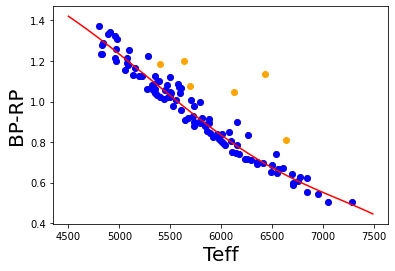

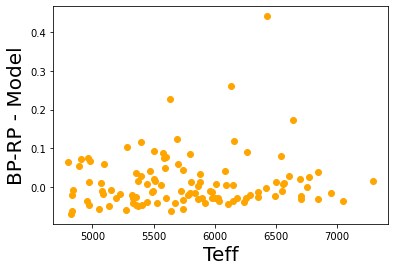

In [15]:
i_pleiades = np.where(  (Pleiades_LAMOST['Teff']>4800) & (Pleiades_LAMOST['Teff']<7500) & 
                        (Pleiades_bprp<1.4) & (Pleiades_bprp>0.2))[0]
#Pleiades_Teff = np.array(Pleiades_LAMOST['Teff'],dtype=float)

teff_array = np.arange(4500,7500,10)
#coeff = np.polyfit(Pleiades_Teff[i_pleiades], Pleiades_bprp[i_pleiades],3)
coeff = np.polyfit(Pleiades_LAMOST['Teff'][i_pleiades], Pleiades_LAMOST['BP-RP'][i_pleiades],5)
t2br_v1 = np.poly1d(coeff)
i_fit = i_pleiades[np.where(abs(Pleiades_LAMOST['BP-RP'][i_pleiades] - t2br_v1(Pleiades_LAMOST['Teff'][i_pleiades]))<0.1)[0]]
coeff = np.polyfit(Pleiades_LAMOST['Teff'][i_fit], Pleiades_LAMOST['BP-RP'][i_fit],5)
pleiades_t2br = np.poly1d(coeff)

plt.scatter(Pleiades_LAMOST['Teff'][i_pleiades], Pleiades_LAMOST['BP-RP'][i_pleiades],c='orange')
plt.scatter(Pleiades_LAMOST['Teff'][i_fit], Pleiades_LAMOST['BP-RP'][i_fit],c='blue')
plt.plot(teff_array, pleiades_t2br(teff_array),c='red')
plt.xlabel('Teff',fontsize=20)
plt.ylabel('BP-RP',fontsize=20)
plt.show()

plt.scatter(Pleiades_LAMOST['Teff'][i_pleiades], Pleiades_LAMOST['BP-RP'][i_pleiades] - pleiades_t2br(Pleiades_LAMOST['Teff'][i_pleiades]),c='orange')
plt.xlabel('Teff',fontsize=20)
plt.ylabel('BP-RP - Model',fontsize=20)

plt.show()

#**Reddening for Theia 456**

We compare the color$-$temperature distributions for Theia 456 and the Pleiades to determine the excess reddening toward Theia 456. For Pleiades, we adopt $A_V = 0.12$ mag for converting to the absolute values for Theia 456.

The bulk of the offset and scatter can be explained by $A_V = 0.2$ to $0.7$ mag.

(0.5, 1.3)

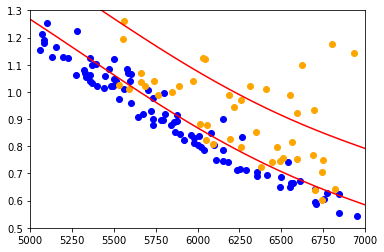

In [16]:
plt.scatter(Pleiades_LAMOST['Teff'][i_fit], Pleiades_LAMOST['BP-RP'][i_fit],c='blue')
iuse = np.where(e_teff < 100)[0]
plt.scatter(Theia456_LAMOST['Teff'][iuse], Theia456_bprp[iuse],c='orange')
av1 = 0.2
plt.plot(teff_array, pleiades_t2br(teff_array)+0.415*(av1-0.12),c='red')
av2 = 0.7
plt.plot(teff_array, pleiades_t2br(teff_array)+0.415*(av2-0.12),c='red')

plt.xlim(5000,7000)
plt.ylim(0.5,1.3)

#**Metallicity**

**Pleiades**

Let's first look at the distribution for the Pleiades. This will illustrate some of the limitations of the LAMOST data.

The systematic trends with $T_{\rm eff}$ are obvious. These systematics mean we cannot simply take a median to determine the metallicity for a group of stars, and we cannot simply calculate a standard deviation to determine the dispersion. Instead, these calculations must be done relative to this systematic pattern that is common to all stars.

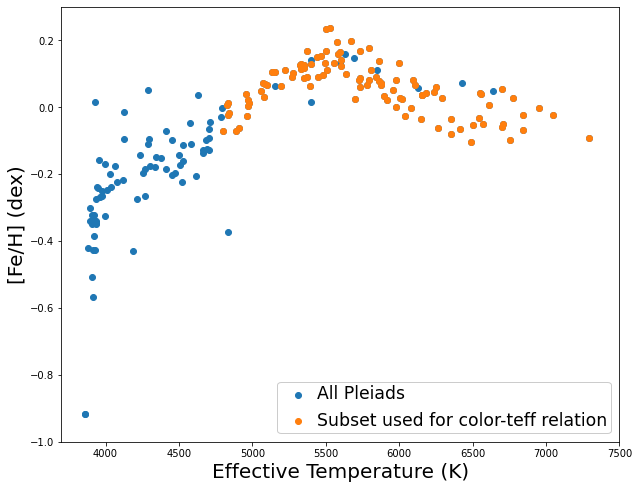

In [17]:
fig, ax1 = plt.subplots(figsize=(10,8))

ax1.scatter(Pleiades_LAMOST['Teff'], Pleiades_LAMOST['[Fe/H]'], label='All Pleiads')
ax1.scatter(Pleiades_LAMOST['Teff'][i_fit], Pleiades_LAMOST['[Fe/H]'][i_fit],label='Subset used for color-teff relation')
ax1.legend(fancybox=True, framealpha=1, shadow=False, borderpad=0.2, fontsize="xx-large",handletextpad=0.1,loc='lower right')
ax1.set_xlabel('Effective Temperature (K)',fontsize=20)
ax1.set_ylabel('[Fe/H] (dex)',fontsize=20)
ax1.set_ylim(-1,0.3)
ax1.set_xlim(3700,7500)
plt.show()


**Theia 456 Metallicity**

*(Left)* [Fe/H] for full Theia 456 sample compared to the Pleiades; you can see the same systematic pattern where warmer F dwarfs have a lower metallicity than cooler G and early-K dwarfs, but the late-K dwarfs are also lower. 

*(Right)* Zooming in on, what I consider to be, the "good" range of temperature between $5000 < T_{\rm eff} < 6500$ K, we see that the Pleiades and Theia 456 distributions approximately match by adding +0.1 dex to the Theia 456 values. 

Adopting [Fe/H] = $+0.03$ dex for the Pleiades (Soderblom et al. 2009), this means [Fe/H] = $-0.07$ dex for Theia 456. This happens to be pretty much the value of the median for the sample ($-0.08$ dex, which is what is done in the paper currently), but this is a coincidence due to the particular temperature range covered by the LAMOST survey combined with the systematic pattern. If the cluster were a bit more distant, maybe we would lose the later K dwarfs and this would bump up the median.

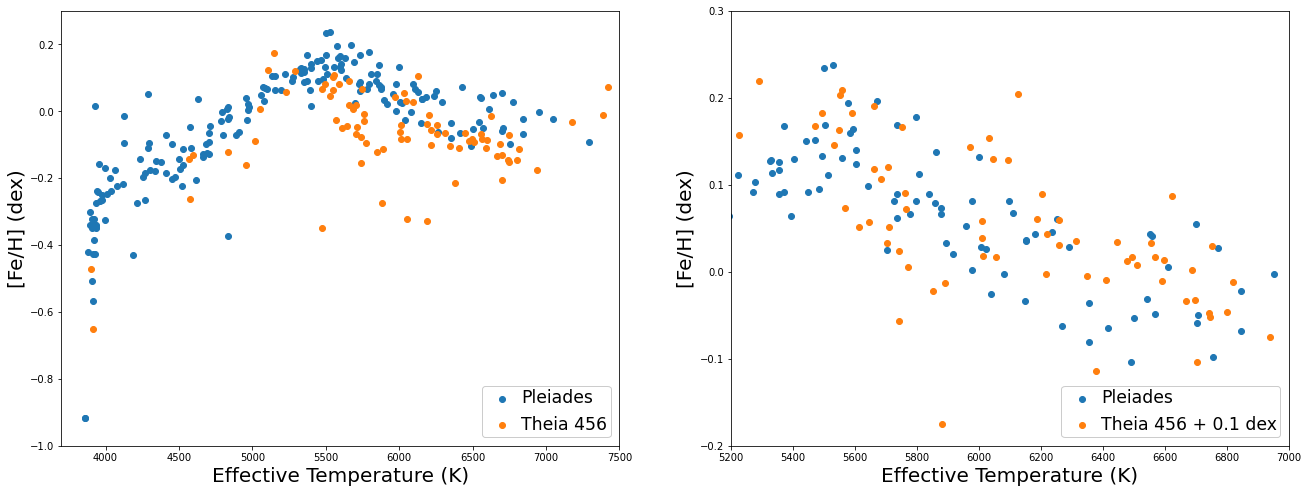

In [18]:
fig, (ax_456, ax_compare) = plt.subplots(1,2,figsize=(22,8))

ax_456.scatter(Pleiades_LAMOST['Teff'], Pleiades_LAMOST['[Fe/H]'], label='Pleiades')
ax_456.scatter(Theia456_LAMOST['Teff'], Theia456_LAMOST['[Fe/H]'], label='Theia 456')
ax_456.legend(fancybox=True, framealpha=1, shadow=False, borderpad=0.2, fontsize="xx-large",handletextpad=0.1,loc='lower right')
ax_456.set_xlabel('Effective Temperature (K)',fontsize=20)
ax_456.set_xlabel('[Fe/H] (dex)',fontsize=20)
ax_456.set_ylim(-1,0.3)
ax_456.set_xlim(3700,7500)
ax_456.set_xlabel('Effective Temperature (K)',fontsize=20)
ax_456.set_ylabel('[Fe/H] (dex)',fontsize=20)


ax_compare.scatter(Pleiades_LAMOST['Teff'][i_fit], Pleiades_LAMOST['[Fe/H]'][i_fit],label='Pleiades')
ax_compare.scatter(Theia456_LAMOST['Teff'], Theia456_LAMOST['[Fe/H]']+0.1, label='Theia 456 + 0.1 dex')
ax_compare.legend(fancybox=True, framealpha=1, shadow=False, borderpad=0.2, fontsize="xx-large",handletextpad=0.1,loc='lower right')
ax_compare.set_xlabel('Effective Temperature (K)',fontsize=20)
ax_compare.set_ylabel('[Fe/H] (dex)',fontsize=20)
ax_compare.set_ylim(-0.2,0.3)
ax_compare.set_xlim(5200,7000)

plt.show()


**Dispersion and Uncertainties**

Here, we plot teff vs its error, feh vs its error, and teff vs feh error. We can see that stars in Theia 456 generally have more uncertain spectroscopic properties. This is due to the lower $S/N$ for these more distant stars compared to those in the Pleiades. Regarding [Fe/H], stars cooler than $T_{\rm eff} \lesssim 6000$ K all have very elevated errors. 

So why do the distributions appear to have similar scatter? Well, maybe the Pleiades errors are not realistic. Also, there are other issues at work: magnetic activity can bias spectroscopic measurements ([Yana Galarza et al. 2019](https://ui.adsabs.harvard.edu/abs/2020ApJ...895...52S/abstract), [Spina et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...895...52S/abstract)), we have not filtered out rapid stars (which can smear lines from Doppler broadening, but that shouldn't matter here because the line spread function is dominated by the low spectral resolution; but rotation correlates with activity, which could be an issue), we have not filtered out binaries, and maybe there are other reasons. I doubt large intrinsic dispersion is a cause, because that would have been found years ago at higher resolution.

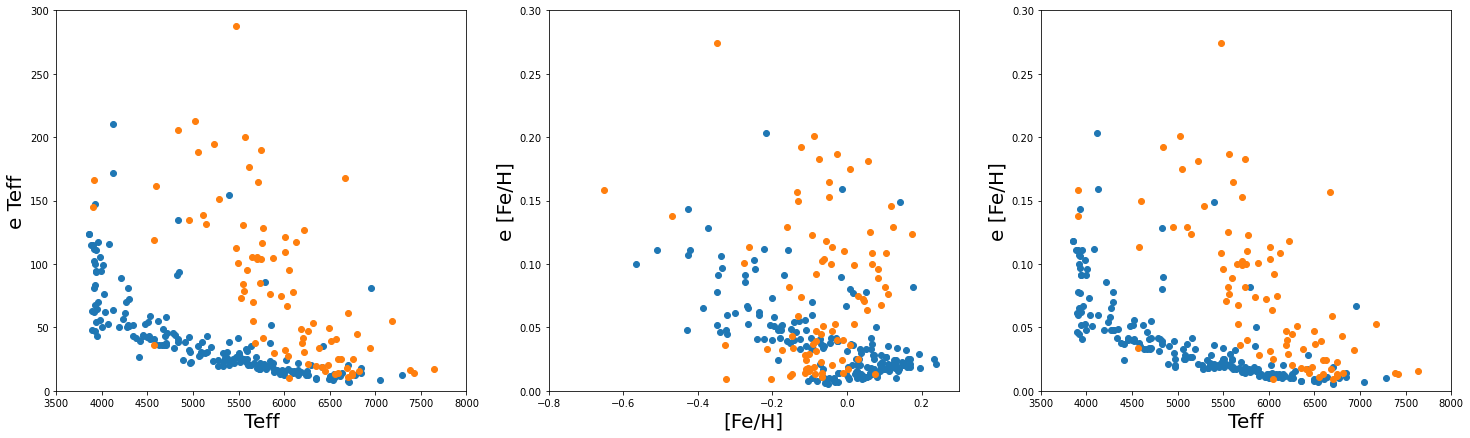

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(25,7))

ax1.scatter(Pleiades_LAMOST['Teff'], Pleiades_LAMOST['e_Teff'], label='Pleiades')
ax1.scatter(Theia456_LAMOST['Teff'], Theia456_LAMOST['e_Teff'], label='Theia 456')
ax1.set_ylim(0,300)
ax1.set_xlim(3500,8000)
ax1.set_xlabel('Teff',fontsize=20)
ax1.set_ylabel('e Teff',fontsize=20)
ax_456.legend(fancybox=True, framealpha=1, shadow=False, borderpad=0.2, fontsize="xx-large",handletextpad=0.1,loc='lower right')


ax2.scatter(Pleiades_LAMOST['[Fe/H]'], Pleiades_LAMOST['e_[Fe/H]'])
ax2.scatter(Theia456_LAMOST['[Fe/H]'], Theia456_LAMOST['e_[Fe/H]'])
ax2.set_ylim(0,0.3)
ax2.set_xlim(-0.8,0.3)
ax2.set_xlabel('[Fe/H]',fontsize=20)
ax2.set_ylabel('e [Fe/H]',fontsize=20)

ax3.scatter(Pleiades_LAMOST['Teff'], Pleiades_LAMOST['e_[Fe/H]'])
ax3.scatter(Theia456_LAMOST['Teff'], Theia456_LAMOST['e_[Fe/H]'])
ax3.set_ylim(0,0.3)
ax3.set_xlim(3500,8000)
ax3.set_xlabel('Teff',fontsize=20)
ax3.set_ylabel('e [Fe/H]',fontsize=20)

plt.show()

#**CMD**

When plotting the CMD, we should use the parallaxes to remove the distance dependence on the magnitude. The main trouble here is parallax errors. However, we can (and should) filter out stars with high ruwe (>1.2), which can have bogus parallaxes, and the parallax errors due to faintness are really only an issue for $G > 16$, which we can see below.


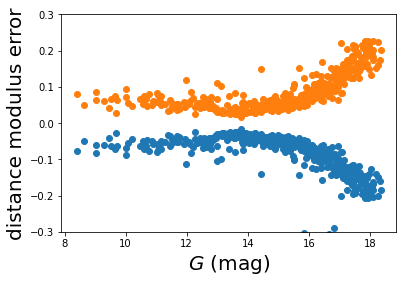

In [20]:
plt.scatter(Theia456_Gmag, 5*np.log10(100/(theia_data['PARALLAX'][i456]+theia_data['PARALLAX_ERROR'][i456])) - 5*np.log10(100/theia_data['PARALLAX'][i456]))
plt.scatter(Theia456_Gmag, 5*np.log10(100/(theia_data['PARALLAX'][i456]-theia_data['PARALLAX_ERROR'][i456])) - 5*np.log10(100/theia_data['PARALLAX'][i456]))
plt.ylim(-0.3,0.3)
plt.xlabel("$G$ (mag)",fontsize=20)
plt.ylabel('distance modulus error', fontsize=20)
plt.show()

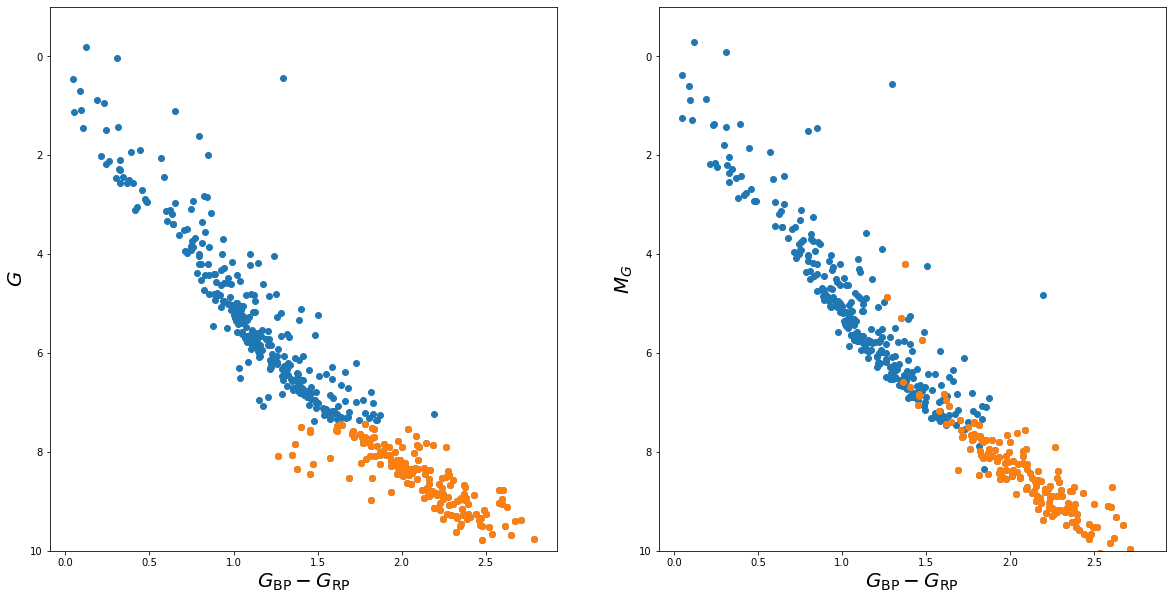

In [21]:
ifaint = np.where(Theia456_Gmag > 16)[0]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.scatter(Theia456_bprp, Theia456_Gmag - np.median(Theia456_dm))
ax1.scatter(Theia456_bprp[ifaint], Theia456_Gmag[ifaint] - np.median(Theia456_dm))
ax1.set_ylim(10,-1)
ax1.set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$',fontsize=20)
ax1.set_ylabel('$G$',fontsize=20)

ax2.scatter(Theia456_bprp, Theia456_MG)
ax2.scatter(Theia456_bprp[ifaint], Theia456_MG[ifaint])
ax2.set_ylim(10,-1)
ax2.set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$',fontsize=20)
ax2.set_ylabel('$M_G$',fontsize=20)
plt.show()

The funny thing is, it kind of looks like the left CMD using apparent $G$ is tighter at the upper left than in the right using absolute $M_G$. However, this can be coincidental from the high amount of differential extinction/reddening. 

Is using an average distance modulus a good assumption? According to the plots below, there isn't much tilt toward or away from us. Probably why it looks so elongated on the sky. So most stars have the same distance modulus. Still, the parallaxes are precise enough for the stars that matter, so it is best to use them.

Text(0, 0.5, 'Parallax')

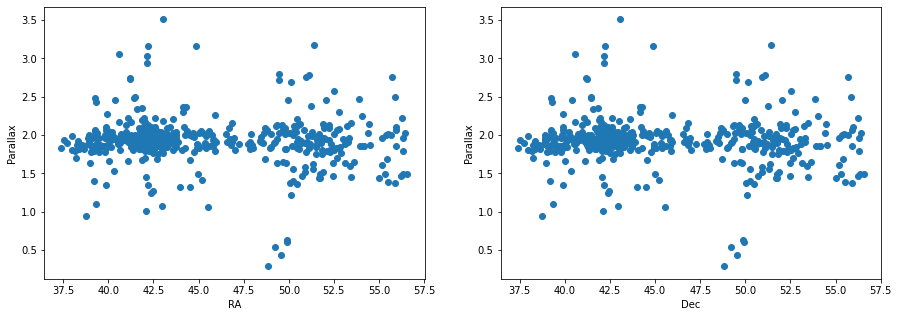

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.scatter(Theia456_RA, theia_data['PARALLAX'][i456])
ax1.set_xlabel('RA')
ax1.set_ylabel('Parallax')

ax2.scatter(Theia456_Dec, theia_data['PARALLAX'][i456])
ax2.set_xlabel('Dec')
ax2.set_ylabel('Parallax')


#**Isochrone fitting troubles**

Let's fit an isochrone to the Pleiades CMD. First, we need an isochrone model. I downloaded a grid of [PARSEC models](http://stev.oapd.inaf.it/cgi-bin/cmd) with [Fe/H] = +0.03 dex (Soderblom et al. 2009) and $A_V = 0.12$ mag (me and others) with Gaia EDR3 filters and ages between 100-400 Myr.

In [23]:
file_isochrone = glob(dir_drive+'Isochrones/*PARSEC-Pleiades-feh_and_Av*')
isochrone = ascii.read(file_isochrone[0], delimiter=r'\s')


we need to select isochrones out of the grid. Here's a function for locating the entry in an array most similar to a desired value.

In [24]:
def findel(value, array):
  np_array = np.array(array)
  iloc = np.argmin(abs(np_array - value))
  return iloc

Now, let's plot the Pleiades CMD and overlay isochrones at (*left*) 120 Myr  and (*right*) 200 Myr. The 200 Myr model is clearly a better fit. The age is also wrong. We know the age is 120 Myr from the detection and modeling of the lithium depletion boundary (e.g., Stauffer et al. 1998). Why the discrepancy? I'm not sure. Maybe we should try other filters just to see.

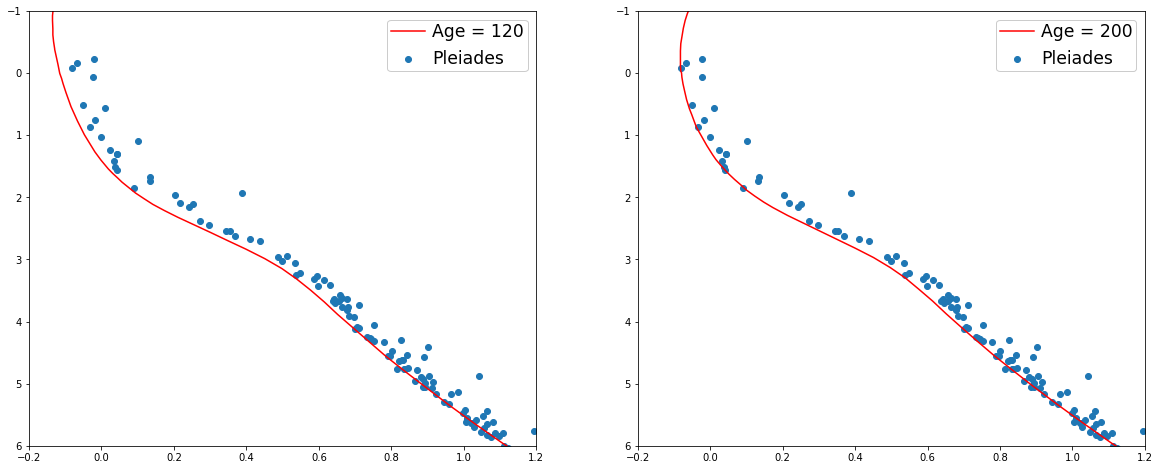

In [25]:
iuse = np.where(Pleiades_edr3['ruwe']<1.2)[0]
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.scatter(Pleiades_edr3['bp_rp'][iuse], Pleiades_edr3['Gmag'][iuse] - 5*np.log10(100/Pleiades_edr3['parallax'][iuse]),label='Pleiades')
age = 120
lages = np.unique(isochrone['logAge'])
iage = findel(np.log10(age*1e6),lages)
iu = np.where((isochrone['logAge'] == lages[iage]) & (isochrone['label'] < 4))
ax1.plot(isochrone['G_BPmag'][iu[0]] - isochrone['G_RPmag'][iu[0]],isochrone['Gmag'][iu[0]], c='red', label='Age = '+str(age))
ax1.set_ylim(6,-1)
ax1.set_xlim(-0.2,1.2)
ax1.legend(fancybox=True, framealpha=1, shadow=False, borderpad=0.2, fontsize="xx-large",handletextpad=0.4,loc='upper right')


ax2.scatter(Pleiades_edr3['bp_rp'][iuse], Pleiades_edr3['Gmag'][iuse] - 5*np.log10(100/Pleiades_edr3['parallax'][iuse]),label='Pleiades')
age = 200
lages = np.unique(isochrone['logAge'])
iage = findel(np.log10(age*1e6),lages)
iu = np.where((isochrone['logAge'] == lages[iage]) & (isochrone['label'] < 4))
ax2.plot(isochrone['G_BPmag'][iu[0]] - isochrone['G_RPmag'][iu[0]],isochrone['Gmag'][iu[0]], c='red', label='Age = '+str(age))
ax2.set_ylim(6,-1)
ax2.set_xlim(-0.2,1.2)
ax2.legend(fancybox=True, framealpha=1, shadow=False, borderpad=0.2, fontsize="xx-large",handletextpad=0.4,loc='upper right')

**Let's try 2MASS**

In [26]:
# Cross-match with 2MASS
#lit_table = Table.from_pandas(Pleiades_edr3)
tm = XMatch.query(cat1=Pleiades_edr3,
                  cat2='vizier:II/246/out',
                  max_distance=1 * units.arcsec, 
                  colRA1='ra', colDec1='dec')
pleiades_2mass = tm.to_pandas()
pleiades_2mass[0:3]

,angDist_1,angDist_2,Source,Cluster,RAdeg,DEdeg,Gmag,plx,e_plx,Simbad,_RA,_DE,ra_epoch2000,dec_epoch2000,errHalfMaj_1,errHalfMin_1,errPosAng_1,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,astrometric_n_good_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,pseudocolour,pseudocolour_error,visibility_periods_used,ruwe,...,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_mag,phot_bp_rp_excess_factor,bp_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,panstarrs1,sdssdr13,skymapper2,urat1,phot_g_mean_mag_error,phot_bp_mean_mag_error,phot_rp_mean_mag_error,phot_g_mean_mag_corrected,phot_g_mean_mag_error_corrected,phot_g_mean_flux_corrected,phot_bp_rp_excess_factor_corrected,ra_epoch2000_error,dec_epoch2000_error,ra_dec_epoch2000_corr,2MASS,RAJ2000,DEJ2000,errHalfMaj_2,errHalfMin_2,errPosAng_2,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag,Qfl,Rfl,X,MeasureJD
0,0.771723,0.722380,66597767189992832,Pleiades,58.42074,24.41921,15.112,7.164,0.052,Simbad,58.42066,24.41940,58.420660,24.419397,0.000680,0.000411,77.10,66597767189992832,58.420748,0.0304,24.419203,0.0206,7.2480,0.0327,221.6400,47.140,17.975,0.042,-43.579,0.028,358,2.1176,414.67,0.072,1.148,31,NaN,NaN,16,1.080,...,16.374218,20397.1,13.973975,1.403,2.400243,NaN,NaN,0,NaN,NaN,137300584207013616,<NA>,<NA>,573031459,0.002880,0.005038,0.004287,15.093363,0.002880,17282.3,0.011,0.6695,0.4281,0.2234,03534095+2425098,58.420632,24.419390,0.06,0.06,90,12.499,11.831,11.583,0.021,0.028,0.024,AAA,222,0,2.451540e+06
1,0.775973,0.754494,66652467893487488,Pleiades,58.08615,24.56531,14.524,7.143,0.010,Simbad,58.08606,24.56550,58.086059,24.565502,0.000497,0.000261,91.59,66652467893487488,58.086149,0.0218,24.565304,0.0126,7.1802,0.0219,327.6251,48.300,18.501,0.031,-44.616,0.017,377,-0.4987,346.56,0.000,0.000,31,NaN,NaN,16,0.981,...,15.654358,33308.5,13.441506,1.379,2.212852,NaN,NaN,0,NaN,NaN,137470580861058960,<NA>,<NA>,573031059,0.002820,0.004734,0.004231,14.509749,0.002820,29583.3,0.014,0.4970,0.2609,-0.0383,03522064+2433557,58.086031,24.565491,0.08,0.07,90,12.083,11.367,11.157,0.027,0.030,0.021,AAA,222,0,2.451531e+06
2,0.906444,0.771282,66581549393480704,Pleiades,58.61864,24.32094,13.597,7.372,0.025,Simbad,58.61855,24.32114,58.618550,24.321138,0.000331,0.000184,88.78,66581549393480704,58.618642,0.0160,24.320930,0.0091,7.4196,0.0159,467.2317,50.403,18.822,0.020,-46.757,0.012,401,0.6102,389.45,0.000,0.000,31,NaN,NaN,18,1.021,...,14.450566,68132.0,12.664517,1.307,1.786049,NaN,NaN,0,NaN,NaN,137180586185935680,<NA>,<NA>,572031044,0.002854,0.003883,0.004184,13.582582,0.002854,69488.7,0.000,0.3310,0.1837,0.0265,03542844+2419161,58.618522,24.321157,0.09,0.07,90,11.449,10.784,10.620,0.019,0.027,0.020,AAA,222,0,2.451509e+06


In [27]:
file_isochrone = glob(dir_drive+'Isochrones/*PARSEC-Pleiades-feh_and_Av*2*')
iso2mass = ascii.read(file_isochrone[0], delimiter=r'\s')
iso2mass[0:3]

Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,McoreTP,C_O,period0,period1,period2,period3,period4,pmode,Mloss,tau1m,X,Y,Xc,Xn,Xo,Cexcess,Z,mbolmag,Jmag,Hmag,Ksmag
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0157,0.03,8.0,0.0900000036,1.0816895962,0.09,-2.757,3.3997,4.7,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-3.31e-16,0.0,0.7077,0.2765,0.002836,0.0007651,0.006939,-1.0,0.01577,11.663,9.575,8.983,8.668
0.0157,0.03,8.0,0.0934856683,1.1142642498,0.093,-2.729,3.4036,4.704,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-3.45e-16,0.0,0.7077,0.2765,0.002836,0.0007651,0.006939,-1.0,0.01577,11.593,9.505,8.913,8.599
0.0157,0.03,8.0,0.1000000015,1.1711064577,0.1,-2.677,3.411,4.711,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-3.73e-16,0.0,0.7077,0.2765,0.002836,0.0007651,0.006939,-1.0,0.01577,11.462,9.373,8.781,8.468


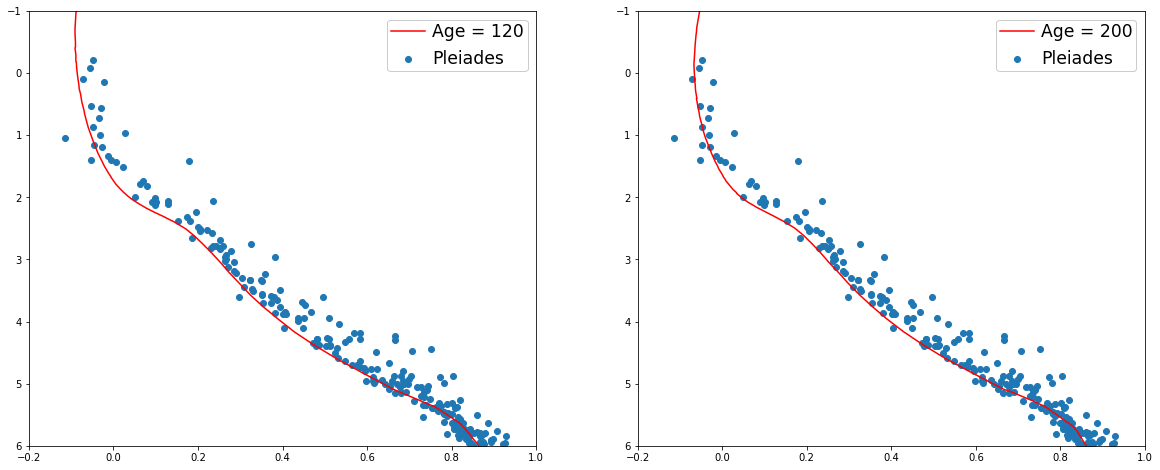

In [28]:
iuse = np.where(pleiades_2mass['ruwe']<1.2)[0]
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.scatter(pleiades_2mass['Jmag'][iuse]-pleiades_2mass['Kmag'][iuse], pleiades_2mass['Jmag'][iuse]-5*np.log10(100/pleiades_2mass['plx'][iuse]),label='Pleiades')
age = 120
lages = np.unique(iso2mass['logAge'])
iage = findel(np.log10(age*1e6),lages)
iu = np.where((iso2mass['logAge'] == lages[iage]) & (iso2mass['label'] < 4))
ax1.plot(iso2mass['Jmag'][iu[0]] - iso2mass['Ksmag'][iu[0]],iso2mass['Jmag'][iu[0]], c='red', label='Age = '+str(age))
ax1.legend(fancybox=True, framealpha=1, shadow=False, borderpad=0.2, fontsize="xx-large",handletextpad=0.4,loc='upper right')
ax1.set_xlim(-0.2,1)
ax1.set_ylim(6,-1)

ax2.scatter(pleiades_2mass['Jmag'][iuse]-pleiades_2mass['Kmag'][iuse], pleiades_2mass['Jmag'][iuse]-5*np.log10(100/pleiades_2mass['plx'][iuse]),label='Pleiades')
age = 200
lages = np.unique(iso2mass['logAge'])
iage = findel(np.log10(age*1e6),lages)
iu = np.where((iso2mass['logAge'] == lages[iage]) & (iso2mass['label'] < 4))

AJ = 0.29434
AK = 0.11838
dav = 0.0
ax2.plot(iso2mass['Jmag'][iu[0]] - iso2mass['Ksmag'][iu[0]] + (AJ-AK)*dav,iso2mass['Jmag'][iu[0]]+ AJ*dav, c='red', label='Age = '+str(age))
ax2.legend(fancybox=True, framealpha=1, shadow=False, borderpad=0.2, fontsize="xx-large",handletextpad=0.4,loc='upper right')
ax2.set_xlim(-0.2,1)
ax2.set_ylim(6,-1)

plt.show()

There seems to be an offset in the main sequence, where the model is too dim (this can be fixed by increasing the metallicity or the reddening/extinction, but that seems to indicate a problem with the model photometry, not our understanding of the cluster's properties).

The age issue doesn't seem to be as significant here. The main issue is that large (percent) changes in age yield very subtle changes in the isochrone, so between 100-200 Myr look very similar. 

In my opinion, however one fits the Theia 456 CMD, they should apply the same data (including how reddening corrections are determined) and procedure to the Pleiades to see what the difference in resulting isochronal age parameters are for the two groups.

#**Rotation**

**get Prot for Pleiades**

In [29]:
# Cross-match with Rebull+2016
pleiades_rotation = XMatch.query(cat1=Pleiades_dr2,
                  cat2='vizier:J/AJ/152/114/table2',
                  max_distance=1 * units.arcsec, 
                  colRA1='ra', colDec1='dec')
pleiades_rotation = pleiades_rotation.to_pandas()
pleiades_rotation[0:3]  

,angDist_1,angDist_2,Source,Cluster,RAdeg,DEdeg,Gmag,plx,e_plx,Simbad_1,_RA,_DE,ra_epoch2000,dec_epoch2000,errHalfMaj,errHalfMin,errPosAng,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,duplicated_source,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,bp_rp,radial_velocity,radial_velocity_error,rv_nb_transits,teff_val,a_g_val,e_bp_min_rp_val,radius_val,lum_val,_RAJ2000,_DEJ2000,EPIC,RAJ2000,DEJ2000,Vmag,Ksmag,(V-K)0,Prot,Mm,P,dd,ddm,shch,beat,cpeak,resc,resd,dScu,cloud,PapI,PapIII,Simbad_2
0,0.796709,0.713791,66942910762588928,Pleiades,57.06457,25.24332,17.076,6.817,0.047,Simbad,57.06448,25.24350,57.064482,25.243502,0.004,0.002,90,66942910762588928,57.064574,0.1289,25.243319,0.0661,6.7753,0.1429,19.192,0.248,-42.444,0.149,0,2784.52,3.44557,17.076488,422.736,12.929,18.786213,3888.37,20.2542,15.787501,2.998712,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,57.06450,25.24353,211139647,57.06450,25.24353,NaN,12.99,5.50,0.4809,best,single,no,no,no,no,no,no,no,no,no,PapI,PapIII,Simbad
1,0.818845,0.755241,66800592725150848,Pleiades,56.54908,24.62213,11.405,7.461,0.072,Simbad,56.54898,24.62232,56.548976,24.622317,0.002,0.001,90,66800592725150848,56.549076,0.0513,24.622125,0.0311,7.5280,0.0562,21.080,0.124,-44.610,0.075,1,517014.00,1406.34000,11.404611,247205.000,2244.300,11.868744,382431.00,2479.0500,10.805536,1.063208,7.65,0.79,8,5252.38,0.0103,0.0060,0.74,0.380,56.54893,24.62231,211103863,56.54893,24.62231,11.71,9.54,2.06,5.9772,best,single,no,no,no,no,no,no,no,no,no,PapI,PapIII,Simbad
2,0.974334,0.746165,66939852745876736,Pleiades,57.07039,25.21493,9.103,7.285,0.065,Simbad,57.07030,25.21512,57.070305,25.215122,0.002,0.001,90,66939852745876736,57.070389,0.0671,25.214926,0.0372,7.2299,0.0763,17.803,0.139,-45.609,0.080,1,4306080.00,2539.97000,9.103162,2593160.000,12826.300,9.316813,2765670.00,20748.9000,8.657421,0.659391,7.02,0.74,4,6613.98,0.7073,0.3657,1.36,3.186,57.07026,25.21517,211138217,57.07026,25.21517,9.13,7.86,1.16,6.7219,best,multi,no,no,no,yes,yes,yes,yes,no,no,PapI,PapIII,Simbad


In [30]:
Pleiades_LAMOST['Prot'] = 0.0

for i in range(len(pleiades_rotation)):
  imatch = np.where(pleiades_rotation['Source'][i] == Pleiades_dr2['Source'])[0]
  if len(imatch) > 0:
    Pleiades_LAMOST['Prot'][imatch[0]] = pleiades_rotation['Prot'][i]

**get Prot for Theia 456**

In [31]:
# load Google Sheets
def load_table(sheet_name, table_name):
  from google.colab import auth
  auth.authenticate_user()
  import gspread
  from oauth2client.client import GoogleCredentials
  gc = gspread.authorize(GoogleCredentials.get_application_default())
  # load the table
  worksheet = gc.open(sheet_name)
  table = worksheet.worksheet(table_name)
  table_data_val = table.get_all_values()
  data = pd.DataFrame.from_records(table_data_val[1:],columns=table_data_val[0])

  return table, data

In [32]:
Theia456_Sheet, Theia456_Prot_Data = load_table('data_Theia_456', 'Prot')

Theia456_Prot_DR2Name = np.array(Theia456_Prot_Data['DR2Name'],dtype=int)
Theia456_Prot_Values = np.array(Theia456_Prot_Data['Prot_Final'],dtype=float)
Theia456_Prot_Source = np.array(Theia456_Prot_Data['Prot_Source'],dtype=str)
Theia456_Prot_Data

,DR2Name,EDR3Name,Gmag,BP_RP,Prot_TESS,Prot_ZTF,Prot_Final,Prot_Source,ZTF_Notes
0,191263006888303360,Gaia EDR3 191263006888303360,16.638172,1.937492,-1,-1,0,None,
1,208504792317742720,Gaia EDR3 208504792317742720,15.032085,1.272452,8.132166083,8.5259554,8.329060742,TESS_ZTF,bspline
2,257811119959501952,Gaia EDR3 257811119959501952,14.686083,1.353808,-14.05532766,-1,0,None,
3,256545856951806720,Gaia EDR3 256545856951806720,16.18437,1.696264,-1,9.5738754,9.5738754,ZTF,
4,256519674831091456,Gaia EDR3 256519674831091456,14.851209,1.278548,-99,7.74757,7.74757,ZTF,
...,...,...,...,...,...,...,...,...,...
463,259058103584493952,Gaia EDR3 259058103584493952,14.114081,1.159239,-5.710871023,2.8390482,0,None,so which is it?
464,258642625627613184,Gaia EDR3 258642625627613184,16.910194,2.11522,-1,0,0,None,
465,259531305898922624,Gaia EDR3 259531305898922624,14.181187,1.130586,-1,2.7211137,2.7211137,ZTF,
466,259469252215220608,Gaia EDR3 259469252215220608,15.124681,1.388141,99,-1,0,None,


In [33]:
Theia456_LAMOST['Prot'] = 0.0
for i in range(len(Theia456_LAMOST)):
  imatch = np.where(theia_data['SOURCE_ID'][i456[i]] == Theia456_Prot_DR2Name)[0]
  if len(imatch) > 0:
    Theia456_LAMOST['Prot'][i] = Theia456_Prot_Values[imatch[0]]

**Prot comparison**

As you can see, the rotation period distribution for Theia 456 is indistinguishable from the distribution for the Pleiades *when plotting against LAMOST temperatures.* These temperatures avoid the interstellar reddening issue (and its strong variation across Theia 456). These data suggest that the Pleiades and Theia 456 share a similar age.

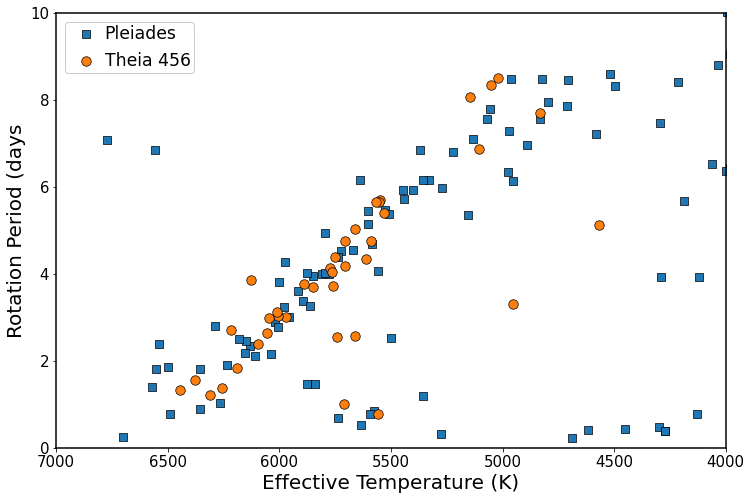

In [34]:
fig, ax = plt.subplots(figsize=(12,8))
iuse = np.where(Pleiades_LAMOST['Prot']>0)[0]
ax.scatter(Pleiades_LAMOST['Teff'][iuse], Pleiades_LAMOST['Prot'][iuse],label='Pleiades',s=60,edgecolors='black',marker='s',linewidth=0.7)
iuse = np.where(Theia456_LAMOST['Prot']>0)[0]
ax.scatter(Theia456_LAMOST['Teff'][iuse], Theia456_LAMOST['Prot'][iuse],label='Theia 456',s=90,edgecolors='black',linewidth=0.7)
ax.legend(fancybox=True, framealpha=1, shadow=False, borderpad=0.2, fontsize="xx-large",handletextpad=0.1,loc='upper left')
ax.set_xlim(7000,4000)
ax.set_ylim(0,10)
# Axes
ax.set_xlabel('Effective Temperature (K)',fontsize=20)
ax.set_ylabel('Rotation Period (days',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.spines['top'].set_linewidth(aw)
ax.spines['left'].set_linewidth(aw)
ax.spines['right'].set_linewidth(aw)
ax.spines['bottom'].set_linewidth(aw)
# Finish
plt.show()